<a href="https://colab.research.google.com/github/oroobyaseen/coursera.exercises/blob/gh-pages/Vgg16%20_Brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation,MaxPooling2D,Dropout
from keras.layers.core import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,LearningRateScheduler,CSVLogger,LambdaCallback,TensorBoard
from keras import regularizers
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
import seaborn as sns
import math
import os

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
%matplotlib inline

In [206]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
train_path = '/content/drive/MyDrive/Lec/Train'
valid_path = '/content/drive/MyDrive/Lec/Val'

train_gen = ImageDataGenerator(
    rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False
)
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True,
  )

train_batches = train_gen.flow_from_directory(directory=train_path, target_size=(224,224),
    classes=['Glioma', 'Meningioma', 'Pituitary tumor'], batch_size=10, shuffle=False)

valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_path, target_size=(224,224), 
    classes=['Glioma', 'Meningioma', 'Pituitary tumor'], batch_size=10, shuffle=False)



Found 2456 images belonging to 3 classes.
Found 616 images belonging to 3 classes.


In [4]:
IMAGE_SIZE = [224, 224]

In [48]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [6]:

from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras import layers

In [49]:
# don't train existing weights
for layer in vgg16.layers:
   layer.trainable = False

In [50]:
x = vgg16.output
x = layers.Flatten()(x)
#x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs=vgg16.inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [45]:
model5_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model5_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model5_mcp = ModelCheckpoint(filepath = 'model5_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

In [51]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', tf.keras.metrics.AUC()])

In [52]:
history = model.fit_generator(generator=train_batches,
                                    #steps_per_epoch=len(train_batches),
                                 validation_data=valid_batches, 
                                 #validation_steps=len(valid_batches), 
                                    epochs=30,  callbacks=[model5_es, model5_rlr, model5_mcp])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


246/246 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.7529 - auc_2: 0.8961

246/246 [==============================] - 24s 92ms/step - loss: 0.4882 - accuracy: 0.7529 - auc_2: 0.8961 - val_loss: 0.2027 - val_accuracy: 0.8782 - val_auc_2: 0.9756 - lr: 0.0010
Epoch 2/30
246/246 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.8473 - auc_2: 0.9578

246/246 [==============================] - 21s 87ms/step - loss: 0.2402 - accuracy: 0.8473 - auc_2: 0.9578 - val_loss: 0.2072 - val_accuracy: 0.8685 - val_auc_2: 0.9656 - lr: 0.0010
Epoch 3/30
246/246 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.8815 - auc_2: 0.9700

246/246 [==============================] - 22s 91ms/step - loss: 0.1953 - accuracy: 0.8815 - auc_2: 0.9700 - val_loss: 0.1713 - val_accuracy: 0.8799 - val_auc_2: 0.9757 - lr: 0.0010
Epoch 4/30
246/246 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.8913 - auc_2: 0.9744

246/246 [==============================] - 22s 90ms/step - loss: 0.1769 - accuracy: 0.8913 - auc_2: 0.9744 - val_loss: 0.1757 - val_accuracy: 0.8994 - val_auc_2: 0.9719 - lr: 0.0010
Epoch 5/30
246/246 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9027 - auc_2: 0.9794

246/246 [==============================] - 23s 92ms/step - loss: 0.1544 - accuracy: 0.9027 - auc_2: 0.9794 - val_loss: 0.1198 - val_accuracy: 0.9221 - val_auc_2: 0.9857 - lr: 0.0010
Epoch 6/30
246/246 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9088 - auc_2: 0.9811

246/246 [==============================] - 23s 91ms/step - loss: 0.1477 - accuracy: 0.9088 - auc_2: 0.9811 - val_loss: 0.1571 - val_accuracy: 0.8912 - val_auc_2: 0.9761 - lr: 0.0010
Epoch 7/30
246/246 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9031 - auc_2: 0.9774

246/246 [==============================] - 23s 91ms/step - loss: 0.1570 - accuracy: 0.9031 - auc_2: 0.9774 - val_loss: 0.1902 - val_accuracy: 0.8734 - val_auc_2: 0.9680 - lr: 0.0010
Epoch 8/30
246/246 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9214 - auc_2: 0.9841

246/246 [==============================] - 22s 91ms/step - loss: 0.1353 - accuracy: 0.9214 - auc_2: 0.9841 - val_loss: 0.1541 - val_accuracy: 0.9123 - val_auc_2: 0.9789 - lr: 0.0010
Epoch 9/30
246/246 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9206 - auc_2: 0.9868

246/246 [==============================] - 24s 98ms/step - loss: 0.1199 - accuracy: 0.9206 - auc_2: 0.9868 - val_loss: 0.1671 - val_accuracy: 0.9042 - val_auc_2: 0.9702 - lr: 0.0010
Epoch 10/30
246/246 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9121 - auc_2: 0.9840

246/246 [==============================] - 22s 88ms/step - loss: 0.1330 - accuracy: 0.9121 - auc_2: 0.9840 - val_loss: 0.1133 - val_accuracy: 0.9367 - val_auc_2: 0.9864 - lr: 0.0010
Epoch 11/30
246/246 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9222 - auc_2: 0.9864

246/246 [==============================] - 22s 91ms/step - loss: 0.1195 - accuracy: 0.9222 - auc_2: 0.9864 - val_loss: 0.1080 - val_accuracy: 0.9432 - val_auc_2: 0.9847 - lr: 0.0010
Epoch 12/30
246/246 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9406 - auc_2: 0.9916

246/246 [==============================] - 22s 88ms/step - loss: 0.0943 - accuracy: 0.9406 - auc_2: 0.9916 - val_loss: 0.1266 - val_accuracy: 0.9302 - val_auc_2: 0.9807 - lr: 0.0010
Epoch 13/30
246/246 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9397 - auc_2: 0.9904

246/246 [==============================] - 22s 90ms/step - loss: 0.0915 - accuracy: 0.9397 - auc_2: 0.9904 - val_loss: 0.1255 - val_accuracy: 0.9351 - val_auc_2: 0.9821 - lr: 0.0010
Epoch 14/30
246/246 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9479 - auc_2: 0.9930

246/246 [==============================] - 22s 88ms/step - loss: 0.0783 - accuracy: 0.9479 - auc_2: 0.9930 - val_loss: 0.1478 - val_accuracy: 0.9302 - val_auc_2: 0.9722 - lr: 0.0010
Epoch 15/30
246/246 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9568 - auc_2: 0.9931

246/246 [==============================] - 22s 90ms/step - loss: 0.0714 - accuracy: 0.9568 - auc_2: 0.9931 - val_loss: 0.0906 - val_accuracy: 0.9464 - val_auc_2: 0.9911 - lr: 0.0010
Epoch 16/30
246/246 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9605 - auc_2: 0.9952

246/246 [==============================] - 22s 90ms/step - loss: 0.0620 - accuracy: 0.9605 - auc_2: 0.9952 - val_loss: 0.1078 - val_accuracy: 0.9432 - val_auc_2: 0.9866 - lr: 0.0010
Epoch 17/30
246/246 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9568 - auc_2: 0.9928

246/246 [==============================] - 22s 90ms/step - loss: 0.0686 - accuracy: 0.9568 - auc_2: 0.9928 - val_loss: 0.1037 - val_accuracy: 0.9416 - val_auc_2: 0.9866 - lr: 0.0010
Epoch 18/30
246/246 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9634 - auc_2: 0.9940

246/246 [==============================] - 22s 88ms/step - loss: 0.0636 - accuracy: 0.9634 - auc_2: 0.9940 - val_loss: 0.1482 - val_accuracy: 0.9286 - val_auc_2: 0.9784 - lr: 0.0010
Epoch 19/30
246/246 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9589 - auc_2: 0.9956

246/246 [==============================] - 23s 92ms/step - loss: 0.0663 - accuracy: 0.9589 - auc_2: 0.9956 - val_loss: 0.1021 - val_accuracy: 0.9562 - val_auc_2: 0.9866 - lr: 0.0010
Epoch 20/30
246/246 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9629 - auc_2: 0.9944

246/246 [==============================] - 22s 90ms/step - loss: 0.0638 - accuracy: 0.9629 - auc_2: 0.9944 - val_loss: 0.1055 - val_accuracy: 0.9367 - val_auc_2: 0.9813 - lr: 0.0010
Epoch 21/30
246/246 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9564 - auc_2: 0.9930
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


246/246 [==============================] - 23s 91ms/step - loss: 0.0719 - accuracy: 0.9564 - auc_2: 0.9930 - val_loss: 0.1198 - val_accuracy: 0.9416 - val_auc_2: 0.9832 - lr: 0.0010
Epoch 22/30
246/246 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9752 - auc_2: 0.9985

246/246 [==============================] - 22s 89ms/step - loss: 0.0387 - accuracy: 0.9752 - auc_2: 0.9985 - val_loss: 0.0796 - val_accuracy: 0.9643 - val_auc_2: 0.9909 - lr: 2.0000e-04
Epoch 23/30
246/246 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9809 - auc_2: 0.9992

246/246 [==============================] - 22s 91ms/step - loss: 0.0299 - accuracy: 0.9809 - auc_2: 0.9992 - val_loss: 0.0851 - val_accuracy: 0.9659 - val_auc_2: 0.9890 - lr: 2.0000e-04
Epoch 24/30
246/246 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9853 - auc_2: 0.9991

246/246 [==============================] - 23s 93ms/step - loss: 0.0272 - accuracy: 0.9853 - auc_2: 0.9991 - val_loss: 0.0967 - val_accuracy: 0.9659 - val_auc_2: 0.9850 - lr: 2.0000e-04
Epoch 25/30
246/246 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9862 - auc_2: 0.9987

246/246 [==============================] - 24s 96ms/step - loss: 0.0265 - accuracy: 0.9862 - auc_2: 0.9987 - val_loss: 0.0929 - val_accuracy: 0.9610 - val_auc_2: 0.9863 - lr: 2.0000e-04
Epoch 26/30
246/246 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9866 - auc_2: 0.9989

246/246 [==============================] - 22s 89ms/step - loss: 0.0250 - accuracy: 0.9866 - auc_2: 0.9989 - val_loss: 0.0969 - val_accuracy: 0.9610 - val_auc_2: 0.9857 - lr: 2.0000e-04
Epoch 27/30
246/246 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9870 - auc_2: 0.9997

246/246 [==============================] - 23s 93ms/step - loss: 0.0215 - accuracy: 0.9870 - auc_2: 0.9997 - val_loss: 0.0981 - val_accuracy: 0.9627 - val_auc_2: 0.9872 - lr: 2.0000e-04
Epoch 28/30
246/246 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9845 - auc_2: 0.9993
Epoch 28: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


246/246 [==============================] - 23s 91ms/step - loss: 0.0237 - accuracy: 0.9845 - auc_2: 0.9993 - val_loss: 0.0895 - val_accuracy: 0.9643 - val_auc_2: 0.9869 - lr: 2.0000e-04
Epoch 29/30
246/246 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9870 - auc_2: 0.9997

246/246 [==============================] - 24s 96ms/step - loss: 0.0207 - accuracy: 0.9870 - auc_2: 0.9997 - val_loss: 0.0916 - val_accuracy: 0.9610 - val_auc_2: 0.9858 - lr: 4.0000e-05
Epoch 30/30
246/246 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9919 - auc_2: 0.9995

246/246 [==============================] - 23s 91ms/step - loss: 0.0180 - accuracy: 0.9919 - auc_2: 0.9995 - val_loss: 0.1020 - val_accuracy: 0.9627 - val_auc_2: 0.9857 - lr: 4.0000e-05


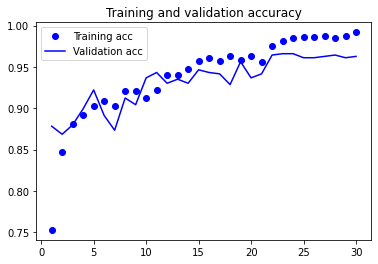

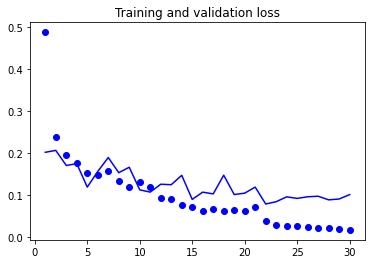

In [53]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.savefig('accuracy.png')
plt.show()

In [54]:
from tensorflow.keras.models import load_model

model.save('model_(1).h5')

In [219]:
test_model = load_model('model_(1).h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


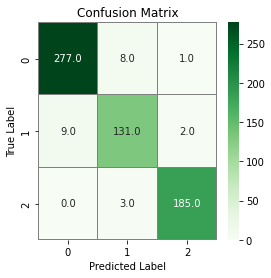

<Figure size 432x288 with 0 Axes>

In [217]:
predictions_1 = test_model.predict_generator(generator=valid_batches, 
                                             steps=len(valid_batches), verbose=0
                                             )

pred_label = np.argmax(predictions_1,axis=1)
classes = np.argmax(predictions_1, axis=1)
cm = confusion_matrix(valid_batches.labels,pred_label)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('confusion_matrix.png')

In [132]:
predictions = test_model.predict_generator(test_batches, steps=1, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [133]:
rounded_prediction = np.argmax(predictions, axis=-1)
for i in rounded_prediction:
    print(i)

0
0
0
0
0
0
0
0
0
0


In [93]:
true_labels = valid_batches .classes
predictions = model.predict_generator(valid_batches )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [94]:
y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

In [96]:
import sklearn

In [97]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

In [98]:
cm

array([[277,   8,   1],
       [  9, 131,   2],
       [  0,   3, 185]])

In [59]:
cm = confusion_matrix(y_true=valid_batches.labels, y_pred=pred_label)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print(classification_report(y_true=valid_batches.labels, y_pred=pred_label))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       286
           1       0.92      0.92      0.92       142
           2       0.98      0.98      0.98       188

    accuracy                           0.96       616
   macro avg       0.96      0.96      0.96       616
weighted avg       0.96      0.96      0.96       616



Confusion matrix, without normalization
[[277   8   1]
 [  9 131   2]
 [  0   3 185]]


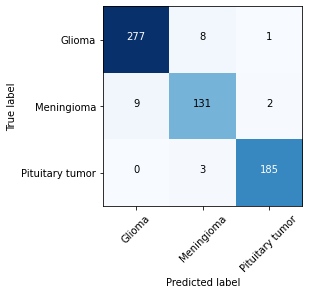

In [60]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm_plot_labels = ['Glioma','Meningioma', 'Pituitary tumor']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [64]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
from itertools import cycle
from sklearn import metrics
from scipy import interp
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [65]:
testY = valid_batches.classes

In [28]:
class_to_label_map = {2 : 'Pituitary tumor', 1 : 'Meningioma', 0 : 'Glioma'}

In [75]:
classes = dict((v, k) for k, v in valid_batches.class_indices.items())
num_classes = len(classes)
num_samples = len(valid_batches)

In [162]:
test_model = load_model('/content/model_(1).h5')

In [163]:
test_imgs, test_labels = next(valid_batches)

In [185]:
rounded_labels = np.argmax(test_labels# , axis=-1
                           )

In [178]:
predictions = test_model.predict_generator( valid_batches, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [179]:
predictions

array([[1.0000000e+00, 3.0657934e-18, 3.0358385e-25],
       [1.0000000e+00, 3.0394756e-11, 8.8509294e-16],
       [1.0000000e+00, 3.6316600e-19, 3.2948668e-26],
       ...,
       [2.6686220e-10, 9.1327948e-08, 9.9999988e-01],
       [2.9161780e-16, 9.9033525e-15, 1.0000000e+00],
       [1.1729276e-17, 2.4056554e-16, 1.0000000e+00]], dtype=float32)

In [180]:
rounded_prediction = np.argmax(predictions, axis=-1)

In [181]:
for i in rounded_prediction:
    print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
0
1
0
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [187]:
cm = confusion_matrix(y_true=true_labels, y_pred=rounded_prediction)

In [188]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[277   8   1]
 [  9 131   2]
 [  0   3 185]]


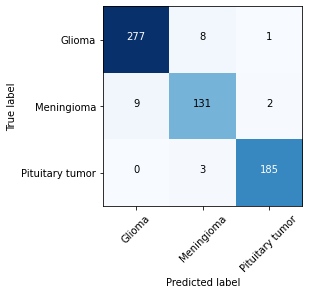

In [207]:
cm_plot_labels = ['Glioma','Meningioma', 'Pituitary tumor']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [208]:
y_score = model.predict_generator(valid_batches)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [210]:
from keras.utils.np_utils import to_categorical  

In [211]:
y_true_categorical = valid_batches.classes
y_true = (to_categorical(y_true_categorical, num_classes = num_classes))


In [213]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
from itertools import cycle
from sklearn import metrics
from scipy import interp
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


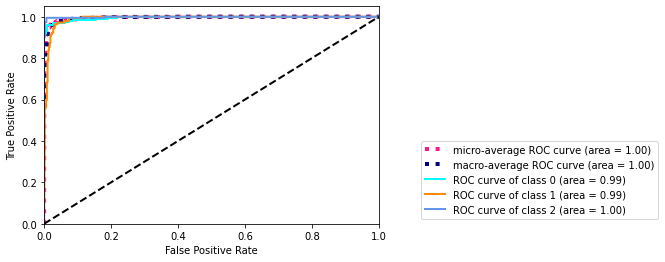

In [215]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#plt.title('Receiver operating characteristic (ROC) to Multi-Class Validation Set (' + model_name + ')')
plt.legend(bbox_to_anchor=(1.85,0), loc="lower right")
#plt.savefig(model_path + '0_results/Model' + '_' + model_name + '_' + str(epochs) + '_epochs_ROC_Validation.png', dpi=600, bbox_inches="tight")
plt.show()


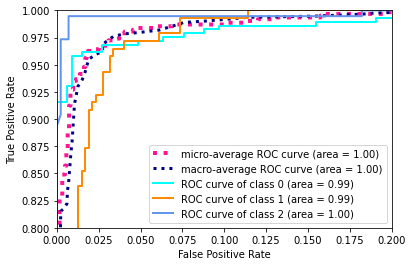

In [216]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()